In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    print(len(physical_devices))
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-02-13 22:53:25.112932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 22:53:25.432771: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 22:53:25.466789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:
2024-02-13 22:53:25.466801: I tensorflow/compiler/xla/stream_execut

In [2]:
from tfcv import *

ModuleNotFoundError: No module named 'tfcv'

In [ ]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.



They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

2024-02-13 22:36:46.696015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


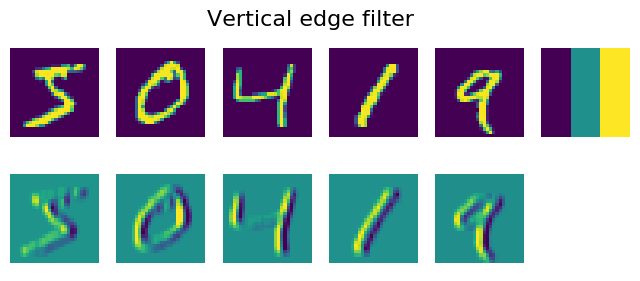

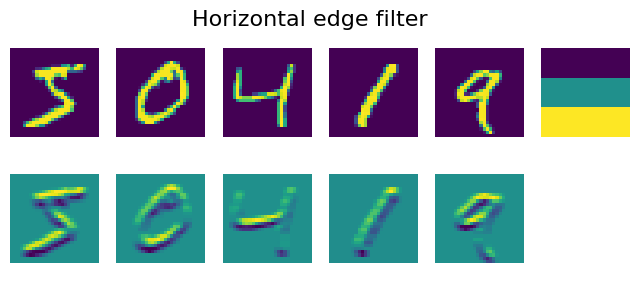

In [ ]:
plot_convolution(x_train[:5],[[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]],'Vertical edge filter')
plot_convolution(x_train[:5],[[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]],'Horizontal edge filter')

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. When it encounters a vertical edge in the image, high spiked value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. In deep learning we construct networks that **learn** the best convolutional filters to solve classification problem on its own.

To do that, we introduce **convolutional layers**.

## Convolutional layers

Convolutional layers are defined using `Conv2d` class. We need to specify the following:
* `filters` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used.

The simplest CNN will contain only one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 24x24x9. The spatial dimension is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels.

After the convolution layer, we flatten 24x24x9 tensor into one vector size of 5184. Then add the linear layer to produce 10 classes and use `relu` activation function in between layers. 

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=9, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 9)         234       
                                                                 
 flatten (Flatten)           (None, 5184)              0         
                                                                 
 dense (Dense)               (None, 10)                51850     
                                                                 
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
_________________________________________________________________


You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. Convolutional networks generalize better which allows us to achieve good results on smaller datasets.

> **Note**: In most of the practical cases, we want to apply convolutional layers to color images. Thus, `Conv2D` layer expects the input to be of the shape $W\times H\times C$, where $W$ and $H$ are width and height of the image, and $C$ is the number of color channels. For grayscale images, we need the same shape with $C=1$.

We need to reshape our data before starting training:

In [ ]:
x_train_c = np.expand_dims(x_train,3)
x_test_c = np.expand_dims(x_test,3)
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=4)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1873/1875 [============================>.] - ETA: 0s - loss: 0.2041 - acc: 0.9417WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f780009c290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

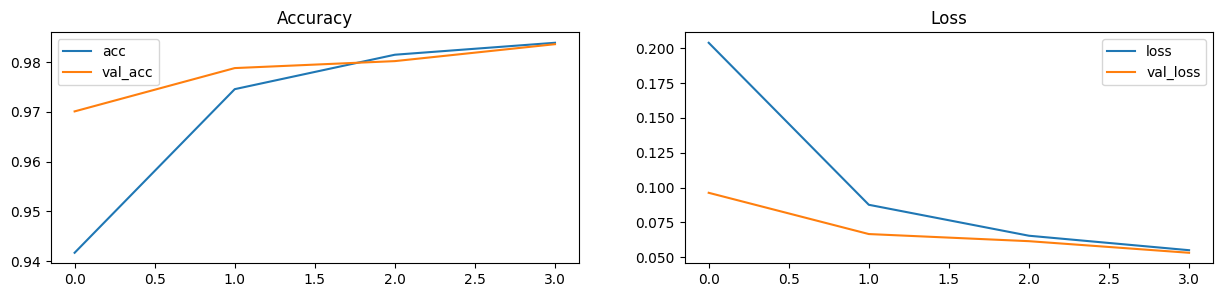

In [ ]:
plot_results(hist)

In [ ]:
print("OI")
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:1])
print("predictions shape:", predictions.shape)

OI
Evaluate on test data


: 